In [ ]:
import yaml
import math
import os

import tensorflow as tf
import tensorflow_datasets as tfds
import imageio

%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy.fft as fft
import numpy.linalg as LA

CFG = yaml.safe_load(open("config.yaml", "r").read())


In [ ]:
# 1.1 and 1.2
def W(n):
  return np.exp(-1J*2*math.pi/n, dtype=complex)

def dft_matrix(N):
  WN = W(N)
  mat = np.ones((N,N),dtype=complex)
  for i in range(1,N):
    for j in range(1,N):
      mat[i,j] = WN**(i*j)
  return mat

def dft_mat(I):
  M,N = I.shape
  WM = dft_matrix(M)
  WN = dft_matrix(N)
  It = np.dot(WM,np.dot(I,WN))
  return It

def idft_mat(I):
  M,N = I.shape
  WM = dft_matrix(M)
  WN = dft_matrix(N)
  It = np.dot(np.conjugate(WM),np.dot(I,np.conjugate(WN)))/(M*N)
  return It

def show(img):
  plt.figure()
  imgplot = plt.imshow(img,cmap='gray')

def plot2(a,b):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10), dpi=80, sharex=True, sharey=True)
  ax[0].imshow(a, cmap='gray')
  ax[1].imshow(b, cmap='gray')

def plot3(a,b,c):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10), dpi=80, sharex=True, sharey=True)
  ax[0].imshow(a)
  ax[1].imshow(b)
  ax[2].imshow(c)

def plot4(a,b,c,d):
  fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10), dpi=80, sharex=True, sharey=True)
  ax[0].imshow(a, cmap='gray')
  ax[1].imshow(b, cmap='gray')
  ax[2].imshow(c, cmap='gray')
  ax[3].imshow(d, cmap='gray')

In [ ]:
n = 2
def get_coord_ints(y_dim, x_dim):
  ys = tf.range(y_dim)[tf.newaxis]
  xs = tf.range(x_dim)[:, tf.newaxis]
  coord_ints = tf.stack([ys+xs-ys, xs+ys-xs], axis=2)
  return coord_ints


def generate_scaled_coordinate_hints(batch_size, img_dim=256):
  spatial_scale = 1. / img_dim
  coord_ints = get_coord_ints(img_dim, img_dim)
  coords = tf.cast(coord_ints, tf.float32)
  coords = tf.stack([coords[:, :, 0] * spatial_scale,
                     coords[:, :, 1] * spatial_scale], axis=-1)
  coords = tf.tile(coords[tf.newaxis], [batch_size, 1, 1, 1])
  return coords

def get_imgs():
  imgs = []
  img = mpimg.imread("6.jpg")
  imgs.append(img)
  img = mpimg.imread("7.jpg")
  imgs.append(img)
  imgs = tf.stack(imgs, axis=0)
  imgs = tf.cast(imgs, tf.float32) / 255.
  labels = tf.range(n)[:, tf.newaxis]
  return imgs, labels

def initialize_fourier_mapping_vector(m, sigma):
  d = 2
  B = tf.random.normal((m, d)) * sigma
  return B

def get_laplacian():
  mean = 0.0
  sig = 100.0
  return np.random.laplace(mean,sig, (256,2))  

def laplacian_mapping(coords, B):
  sin_features = tf.math.sin((2 * math.pi) * (tf.matmul(coords, B, transpose_b=True)))
  cos_features = tf.math.cos((2 * math.pi) * (tf.matmul(coords, B, transpose_b=True)))
  features = tf.concat([sin_features, cos_features], axis=-1)
  print("Laplacian mapping")
  print("Before mapping:",coords.shape)
  print("After mapping:",features.shape)
  return features

def fourier_mapping(coords, B):
  sin_features = tf.math.sin((2 * math.pi) * (tf.matmul(coords, B, transpose_b=True)))
  cos_features = tf.math.cos((2 * math.pi) * (tf.matmul(coords, B, transpose_b=True)))
  features = tf.concat([sin_features, cos_features], axis=-1)
  print("Gaussian mapping")
  print("Before mapping:",coords.shape)
  print("After mapping:",features.shape)
  return features

def basic_mapping(coords):
  sin_features = tf.math.sin((2 * math.pi) * coords)
  cos_features = tf.math.cos((2 * math.pi) * coords)
  features = tf.concat([sin_features, cos_features], axis=-1)
  print("Basic mapping")
  print("Before mapping:",coords.shape)
  print("After mapping:",features.shape)
  return features

class Generator(tf.keras.Model):
  """Compositional pattern-producing network, optionally using Fourier features.
  """
  def __init__(self, use_fourier_features):
    super(Generator, self).__init__()
    self.condition_embed = tf.keras.layers.Dense(CFG['units'])
    self.mlps = [tf.keras.layers.Dense(CFG['units']) for _ in range(CFG['layers'])]
    self.mlp_out = tf.keras.layers.Dense(3)
    self.B = initialize_fourier_mapping_vector(m=CFG['m'], sigma=CFG['sigma'])
    self.B1 = initialize_fourier_mapping_vector(m=CFG['m'], sigma=1)
    self.B2 = initialize_fourier_mapping_vector(m=CFG['m'], sigma=50)
    self.use_fourier_features = use_fourier_features


  def call(self, x):
    batch_size = x.shape[0]
    coords = generate_scaled_coordinate_hints(batch_size)
    if self.use_fourier_features == 'gaussian':
      features = fourier_mapping(coords, B=self.B)
    elif self.use_fourier_features == 'g1':
      features = fourier_mapping(coords, B=self.B1)
    elif self.use_fourier_features == 'g20':
      features = fourier_mapping(coords, B=self.B2)      
    elif self.use_fourier_features == 'basic':
      features = basic_mapping(coords)
    elif self.use_fourier_features == 'laplacian':
      features = laplacian_mapping(coords,get_laplacian())
    else:
      features = coords
    for i, mlp in enumerate(self.mlps):
      if i == 0:
        cond_embed = self.condition_embed(x)
        cond_embed = tf.tile(cond_embed[:, tf.newaxis, tf.newaxis], [1, 256, 256, 1])
        x = mlp(features) + cond_embed
      else:
        x = mlp(x)
      x = tf.nn.relu(x)
    x = self.mlp_out(x)
    x = tf.nn.sigmoid(x)
    return x

if __name__ == "__main__":
  imgs, labels = get_imgs()
  output_dim = 3
  
  model = Generator(use_fourier_features='none')
  basic_model = Generator(use_fourier_features='basic')
  gaussian_model = Generator(use_fourier_features='gaussian')
  laplacian_model = Generator(use_fourier_features='lapacian')
  g1 = Generator(use_fourier_features='g1')
  g20 = Generator(use_fourier_features='g20')

  model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(lr=1e-3)
  )
  basic_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(lr=1e-3)
  )
  gaussian_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(lr=1e-3)
  )
  laplacian_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(lr=1e-3)
  )
  g1.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(lr=1e-3)
  )
  g20.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(lr=1e-3)
  )
  e = 200
  model.fit(x=labels, y=imgs, batch_size=n, epochs=e)
  basic_model.fit(x=labels, y=imgs, batch_size=n, epochs=e)
  gaussian_model.fit(x=labels, y=imgs, batch_size=n, epochs=e)
  

Epoch 1/200
1/1 [==============================] - 0s 106ms/step - loss: 0.0767
Epoch 2/200
1/1 [==============================] - 0s 93ms/step - loss: 0.0745
Epoch 3/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0725
Epoch 4/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0709
Epoch 5/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0693
Epoch 6/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0677
Epoch 7/200
1/1 [==============================] - 0s 75ms/step - loss: 0.0658
Epoch 8/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0636
Epoch 9/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0612
Epoch 10/200
1/1 [==============================] - 0s 79ms/step - loss: 0.0588
Epoch 11/200
1/1 [==============================] - 0s 76ms/step - loss: 0.0562
Epoch 12/200
1/1 [==============================] - 0s 75ms/step - loss: 0.0535
Epoch 13/200
1/1 [==============================

In [ ]:
g1.fit(x=labels, y=imgs, batch_size=n, epochs=e)
g20.fit(x=labels, y=imgs, batch_size=n, epochs=e)

Epoch 1/200
Gaussian mapping
Before mapping: (2, 256, 256, 2)
After mapping: (2, 256, 256, 512)
Gaussian mapping
Before mapping: (2, 256, 256, 2)
After mapping: (2, 256, 256, 512)
1/1 [==============================] - 0s 99ms/step - loss: 0.0841
Epoch 2/200
1/1 [==============================] - 0s 86ms/step - loss: 0.0600
Epoch 3/200
1/1 [==============================] - 0s 102ms/step - loss: 0.0547
Epoch 4/200
1/1 [==============================] - 0s 87ms/step - loss: 0.0487
Epoch 5/200
1/1 [==============================] - 0s 87ms/step - loss: 0.0453
Epoch 6/200
1/1 [==============================] - 0s 102ms/step - loss: 0.0450
Epoch 7/200
1/1 [==============================] - 0s 87ms/step - loss: 0.0447
Epoch 8/200
1/1 [==============================] - 0s 108ms/step - loss: 0.0436
Epoch 9/200
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 10/200
1/1 [==============================] - 0s 104ms/step - loss: 0.0419
Epoch 11/200
1/1 [==================

In [ ]:
laplacian_model.fit(x=labels, y=imgs, batch_size=n, epochs=e)

Epoch 1/200
1/1 [==============================] - 0s 79ms/step - loss: 0.0768
Epoch 2/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0745
Epoch 3/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0729
Epoch 4/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0715
Epoch 5/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0701
Epoch 6/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0685
Epoch 7/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0668
Epoch 8/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0648
Epoch 9/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0627
Epoch 10/200
1/1 [==============================] - 0s 87ms/step - loss: 0.0604
Epoch 11/200
1/1 [==============================] - 0s 84ms/step - loss: 0.0579
Epoch 12/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0553
Epoch 13/200
1/1 [==============================]

Basic mapping
Before mapping: (2, 256, 256, 2)
After mapping: (2, 256, 256, 4)
Gaussian mapping
Before mapping: (2, 256, 256, 2)
After mapping: (2, 256, 256, 512)
Gaussian mapping
Before mapping: (2, 256, 256, 2)
After mapping: (2, 256, 256, 512)
Gaussian mapping
Before mapping: (2, 256, 256, 2)
After mapping: (2, 256, 256, 512)
 
     Ground Truth       a)No mapping       b)Basic mapping    c)Gaussian mapping


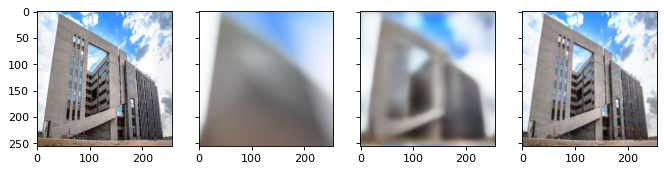

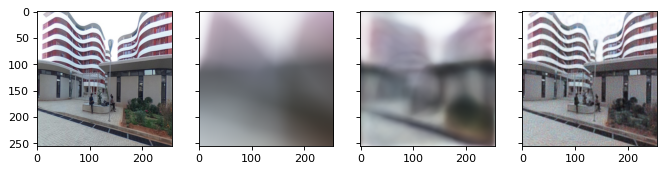

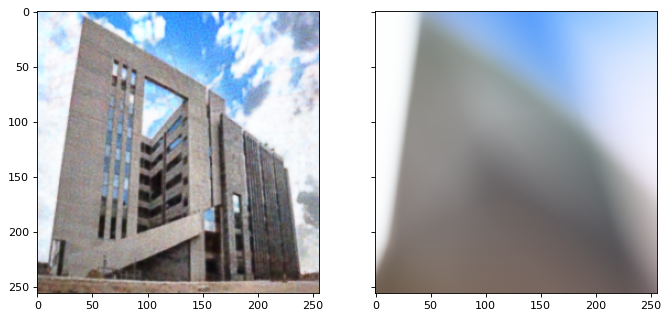

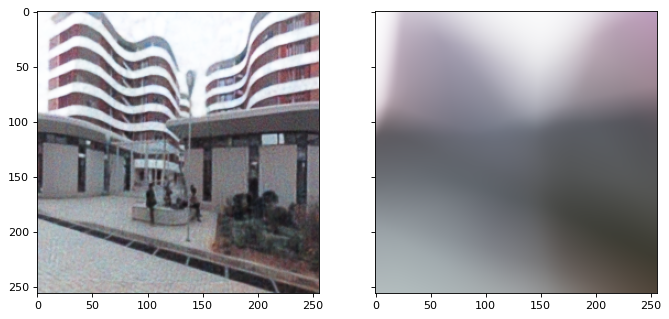

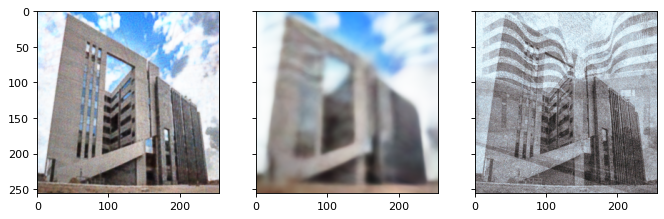

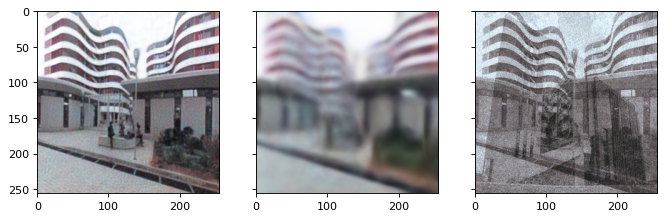

In [ ]:
res1 = []
res2 = []

def predict(imgs, labels, model):
  pred_imgs = model(labels)
  res1.append(pred_imgs[0])
  res2.append(pred_imgs[1])
    
predict(imgs, labels, model)
predict(imgs, labels, basic_model)
predict(imgs, labels, gaussian_model)
predict(imgs, labels, g1)
predict(imgs, labels, g20)
predict(imgs, labels, laplacian_model)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10), dpi=80, sharex=True, sharey=True)
ax[0].imshow(imgs[0], cmap='gray')
ax[1].imshow(res1[0], cmap='gray')
ax[2].imshow(res1[1], cmap='gray')
ax[3].imshow(res1[2], cmap='gray')
fig1, ax1 = plt.subplots(nrows=1, ncols=4, figsize=(10, 10), dpi=80, sharex=True, sharey=True)
ax1[0].imshow(imgs[1], cmap='gray')
ax1[1].imshow(res2[0], cmap='gray')
ax1[2].imshow(res2[1], cmap='gray')
ax1[3].imshow(res2[2], cmap='gray')
plot2(res1[2],res1[5])
plot2(res2[2],res2[5])
plot3(res1[2],res1[3],res1[4])
plot3(res2[2],res2[3],res2[4])
print(' ')
print("     Ground Truth       a)No mapping       b)Basic mapping    c)Gaussian mapping")